# Dating Pools using K-Means Clustering

Previously, we explored a large dataset containing 60,000 anonymized OKCupid users from the year 2012. In this article, we apply K-Means clustering, a machine learning algorithm, to group our OKCupid users into dating pools, as a means to narrow down their potential matches.

Clustering, is a technique which groups similar data points together. Let's use this to group similar people together and recommend who you should date. People in the same cluster as you are the people who we will recommend.

## Feature Selection

We start by reviewing the features of our users. Which, among the features, would you want your date to have in common with you?

In [49]:
expanded_df_backup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59811 entries, 0 to 59945
Data columns (total 48 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 59811 non-null  int64  
 1   body_type           54538 non-null  object 
 2   diet                35481 non-null  object 
 3   drinks              56846 non-null  object 
 4   drugs               45755 non-null  object 
 5   education           53211 non-null  object 
 6   essay0              54351 non-null  object 
 7   essay1              52275 non-null  object 
 8   essay2              50210 non-null  object 
 9   essay3              48375 non-null  object 
 10  essay4              49318 non-null  object 
 11  essay5              49010 non-null  object 
 12  essay6              46085 non-null  object 
 13  essay7              47404 non-null  object 
 14  essay8              40636 non-null  object 
 15  essay9              47245 non-null  object 
 16  ethn

After asking someone which features they would want to have in common with them, the chosen features are:
* Drugs
* Diet
* Pets
* Orientation
* Religion (attitude only)

Let's isolate that subset of features.

In [50]:
clustering_df = sparse_essay_df.copy()
cat_selection = ['drugs', 'orientation',
                'diet_adherence', 'diet_type','religion_attitude', 'dog_preference', 'cat_preference', 'has_dogs',
                'has_cats']
numeric_selection = []
feature_selection = feature_selection_to_list(clustering_df, cat_selection, numeric_selection)
clustering_df = clustering_df[feature_selection]

#Conversion to Scipy csr_matrix
clustering_coo = clustering_df.sparse.to_coo()
clustering_csr = clustering_coo.tocsr()
clustering_csr.get_shape()

(59811, 37)

## Choosing a value of k

Now that we have our subset let's search for the best number of k clusters to use in our model.

In [51]:
#Recommended setting for training Kmeans on Windows
import os
os.environ["OMP_NUM_THREADS"] = "1"

from sklearn.cluster import KMeans

execute = False
if execute:
    num_clusters = list(range(1,200))
    inertias= []
    for i in num_clusters:
      model = KMeans(n_clusters = i)
      model.fit(clustering_csr)
      inertias.append(model.inertia_)

    plt.plot(num_clusters, inertias, '-o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.show()

The Inertia vs k graph we now have below took 5 hours to produce (hence the default setting above to skip execution of the code snippet). Inertia, is a metric which represents how spaced out the points of a cluster are relative to its centroid. A line has been drawn over the tail end of the graph so that we can clearly mark where the graph becomes linear. The specific point where the graph becomes linear is known as the elbow point, and is the number of clusters that we should use.

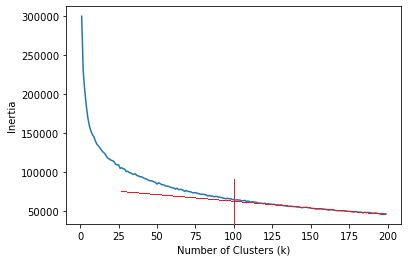

k = 100 is where the linearity begins. Let's create the model we will use for clustering with k = 100.

In [52]:
model = KMeans(n_clusters = 100)
model.fit(clustering_csr)
labels = model.predict(clustering_csr)

Let's investigate the uniformity of our cluster distribution.

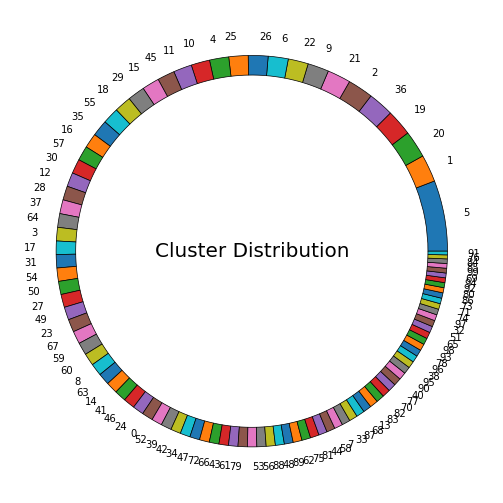

In [53]:
ser_labels  = pd.Series(labels)
ser_labels_props = ser_labels.value_counts()
plt.figure(figsize = (16,9))
plt.pie(x=ser_labels_props.values, labels = ser_labels_props.index,
                wedgeprops=dict(width=0.10,
                                edgecolor="k",
                                linewidth=0.7))
plt.text(0, 0, 'Cluster Distribution', 
                 horizontalalignment = 'center',
                 verticalalignment = 'center',
                 fontsize = 20)
plt.show()

The clusters are somewhat distributed across users. 

## Date Match Recommendations (only interactive if opened with Jupyter Notebooks and required packages are installed)

Let's discover who you can date! Select from the dropdown lists to enter your information. Click the 'Run Interact' button to predict your cluster number and display the profile of a potential date. Your cluster contains users that are similar to you - someone you might want to date! Click Run to see another random profile from your cluster.

* Note that as an experiment, null values have been included as their own category. The model groups people who similarly leave a lot of fields blank. The values of 'nan' or 'None' or 'No Prefix' means that you are not sharing information for that particular field. Go ahead and try out 'nan' and see how that affects your matches.

In [54]:
from ipywidgets import interact_manual
import random

def make_profile(sex, drugs, orientation, diet_adherence, diet_type, religion_attitude,
                 dog_preference, cat_preference, has_dogs, has_cats, show_same_gender):
    
    user_info = [drugs, orientation, diet_adherence, diet_type, religion_attitude,
                 dog_preference, cat_preference, has_dogs, has_cats]
    user_dict = {}
    for each in clustering_df.columns.to_list():
         user_dict[each] = [0]
    for each in user_info:
        user_dict[each] = [1]
    user_df = pd.DataFrame(data=user_dict, index = ['You'])
    sparse_user_df = user_df.copy()
    for each in sparse_user_df.columns.to_list():
        sparse_user_df[each] = pd.arrays.SparseArray(sparse_user_df[each].values, dtype='uint8')
        
    sparse_user_df = sparse_user_df.sparse.to_coo()
    sparse_user_df = sparse_user_df.tocsr()
    
    user_cluster_label = model.predict(sparse_user_df)
    user_cluster = np.where(labels == user_cluster_label)[0]
    print("Your cluster is {}.\nThere are {} users in your cluster.".format(user_cluster_label, len(user_cluster)))
    
    if show_same_gender == False:
        user_sex_dict = {'Male':'m', "Female":'f'}
        user_sex = user_sex_dict[sex]
        #Look for an opposite gender
        while user_sex == user_sex_dict[sex]:
            rand_index = random.randint(0, len(user_cluster))
            rand_user = user_cluster[rand_index]
            user_sex = expanded_df_backup.iloc[rand_user]['sex']
    else:
        rand_index = random.randint(0, len(user_cluster))
        rand_user = user_cluster[rand_index]       

    print("Is this person dateable? Press Run again to see a new recommendation.\n")
    show_user_data(expanded_df_backup.iloc[:,0:31], rand_user)

interact_manual(
    make_profile,
    sex = ['Male', 'Female'],
    drugs = feature_selection_to_list(clustering_df, ['drugs'], []),
    orientation = feature_selection_to_list(clustering_df, ['orientation'], []),
    diet_adherence = feature_selection_to_list(clustering_df, ['diet_adherence'], []),
    diet_type = feature_selection_to_list(clustering_df, ['diet_type'], []),
    religion_attitude = feature_selection_to_list(clustering_df, ['religion_attitude'], []),
    dog_preference = feature_selection_to_list(clustering_df, ['dog_preference'], []),
    cat_preference = feature_selection_to_list(clustering_df, ['cat_preference'], []),
    has_dogs = feature_selection_to_list(clustering_df, ['has_dogs'], []),
    has_cats = feature_selection_to_list(clustering_df, ['has_cats'], []),
    show_same_gender = True
)

interactive(children=(Dropdown(description='sex', options=('Male', 'Female'), value='Male'), Dropdown(descript…

<function __main__.make_profile(sex, drugs, orientation, diet_adherence, diet_type, religion_attitude, dog_preference, cat_preference, has_dogs, has_cats, show_same_gender)>

### Static Image Preview

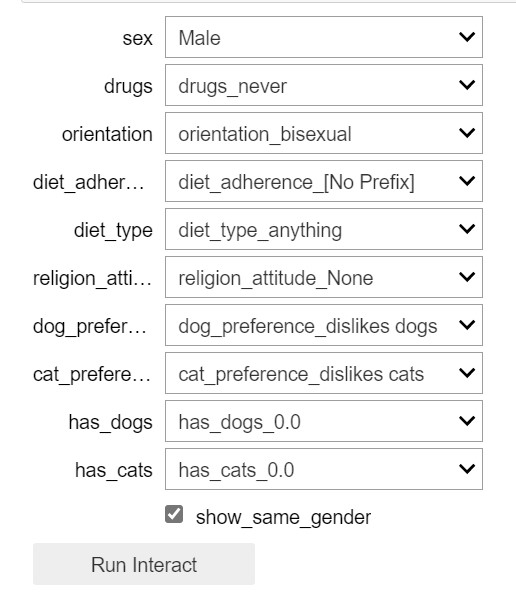

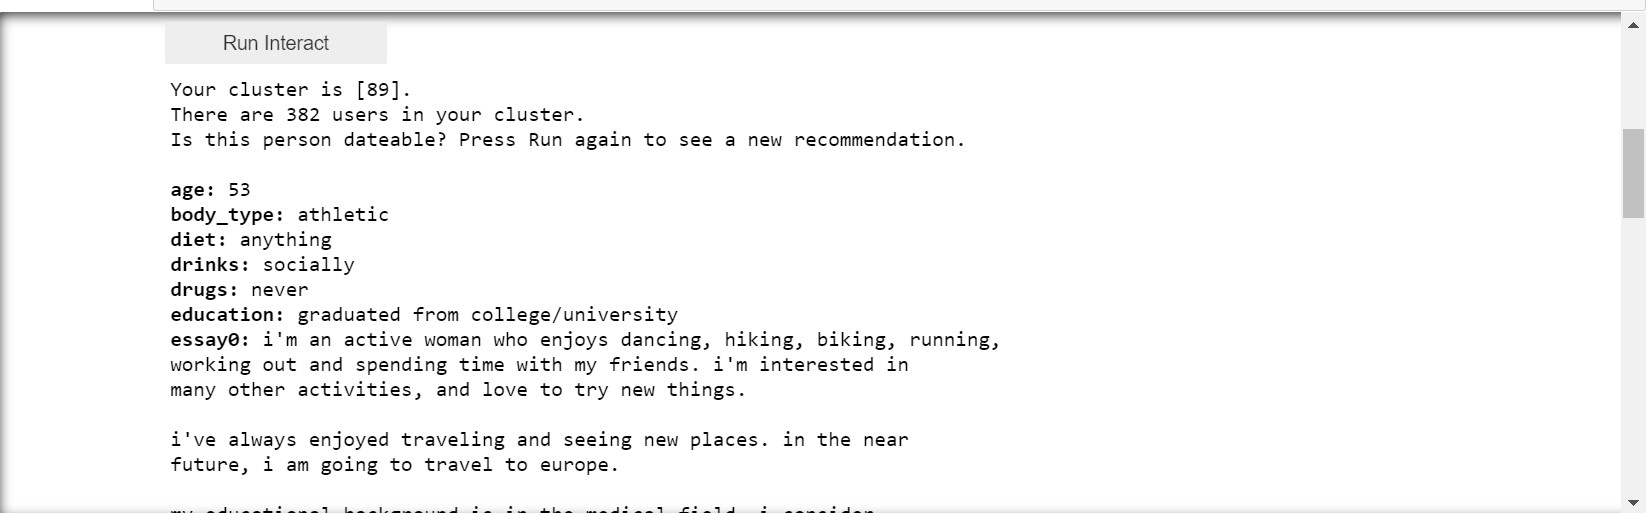

## Date Recommendation using K-Means Clustering Recap

In this section, we accomplished the following:
* Selected features for our model, on the basis of wanting a potential date to be similar for those particular features
* Used the 'elbow method' for selecting a value of k for our k-means clustering model
* Created an interactive interface for presenting profiles of suggested users to date based on input user data